adjust csv to remove space in colony_strength col title. add temp fix in this notebook to notebook 1 so that commas and spaces in colony_strength col are removed.

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf


/home/ldmonte/workspace/SQLite/wmp_bf_efficiency/venv/lib/python3.12/site-packages/numpy/_core/getlimits.py:552: UserWarning: Signature b'\x00\xd0\xcc\xcc\xcc\xcc\xcc\xcc\xfb\xbf\x00\x00\x00\x00\x00\x00' for <class 'numpy.longdouble'> does not match any known type: falling back to type probe function.
This warnings indicates broken support for the dtype!
  machar = _get_machar(dtype)


In [2]:
df = pd.read_csv("../data/processed/bf_efficiency_clean.csv")

assert not df.empty, "Cleaned dataset is empty"


In [4]:
df["colony_strength"] = (
    df["colony_strength"]
      .astype(str)
      .str.replace(",", "", regex=False)
      .pipe(pd.to_numeric, errors="coerce")
)


In [5]:
df["origin"] = df["line_id"].str.extract(r"(LAO|TML)")
df["treatment"] = df["line_id"].str.extract(r"(BRO|AMP)")


In [6]:
model_df = df[[
    "egg_output_total",
    "blood_input_ml",
    "colony_strength",
    "origin",
    "treatment"
]].dropna()

model_df.shape

(158, 5)

In [7]:
baseline_model = smf.ols(
    formula="""
        egg_output_total ~
        blood_input_ml +
        colony_strength
    """,
    data=model_df
).fit()

print(baseline_model.summary())


                            OLS Regression Results                            
Dep. Variable:       egg_output_total   R-squared:                       0.190
Model:                            OLS   Adj. R-squared:                  0.180
Method:                 Least Squares   F-statistic:                     18.22
Date:                Fri, 19 Dec 2025   Prob (F-statistic):           7.84e-08
Time:                        12:40:01   Log-Likelihood:                -2324.4
No. Observations:                 158   AIC:                             4655.
Df Residuals:                     155   BIC:                             4664.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        4.765e+05   2.54e+05     

In [8]:
full_model = smf.ols(
    formula="""
        egg_output_total ~
        blood_input_ml +
        colony_strength +
        C(origin) * C(treatment)
    """,
    data=model_df
).fit()

print(full_model.summary())


                            OLS Regression Results                            
Dep. Variable:       egg_output_total   R-squared:                       0.421
Model:                            OLS   Adj. R-squared:                  0.402
Method:                 Least Squares   F-statistic:                     22.13
Date:                Fri, 19 Dec 2025   Prob (F-statistic):           1.28e-16
Time:                        12:40:11   Log-Likelihood:                -2297.9
No. Observations:                 158   AIC:                             4608.
Df Residuals:                     152   BIC:                             4626.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


In [9]:
baseline_model.rsquared, full_model.rsquared


(np.float64(0.19031975066268758), np.float64(0.4212529500099037))

In [10]:
sm.stats.anova_lm(baseline_model, full_model)


,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,155.0,5.549874e+13,0.0,NaN,NaN,NaN
1,152.0,3.966965e+13,3.0,1.582909e+13,20.217149,4.434087e-11


In [11]:
residuals = full_model.resid
fitted = full_model.fittedvalues


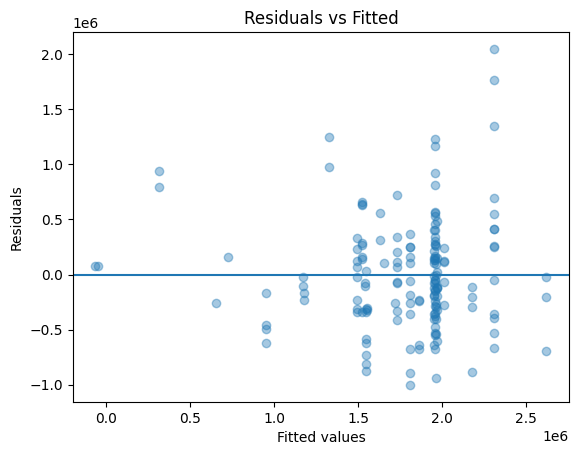

In [12]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(fitted, residuals, alpha=0.4)
plt.axhline(0)
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted")
plt.show()


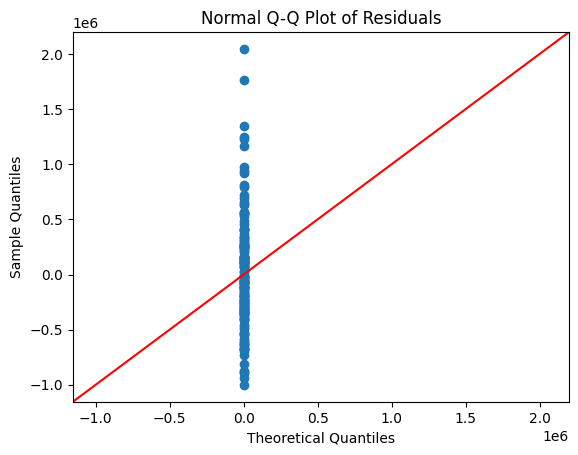

In [13]:
sm.qqplot(residuals, line="45")
plt.title("Normal Q-Q Plot of Residuals")
plt.show()


In [15]:
import pandas as pd
import statsmodels.api as sm

df = pd.read_csv("../data/processed/bf_efficiency_clean.csv")

df["colony_strength"] = (
    df["colony_strength"]
        .str.replace(",", "", regex=False)
        .pipe(pd.to_numeric, errors="coerce")
)

X = df[["blood_input_ml", "temperature_c", "humidity_pct", "colony_strength"]]
y = df["egg_output_total"]


X = sm.add_constant(X)

model = sm.OLS(y, X).fit()
model.summary()

df.columns.tolist()

KeyError: "['temperature_c', 'humidity_pct'] not in index"